# Run Model Bias Analysis with SageMaker Clarify (Post-Training)

## Using SageMaker Processing Jobs

In [67]:
import boto3
import sagemaker
import pandas as pd
import numpy as np

sess   = sagemaker.Session()
bucket = sess.default_bucket()
role = sagemaker.get_execution_role()
region = boto3.Session().region_name

sm = boto3.Session().client(service_name='sagemaker', region_name=region)

In [68]:
%store -r training_job_name

In [69]:
try:
    training_job_name
    print('[OK]')
except NameError:
    print('+++++++++++++++++++++++++++++++')
    print('[ERROR] Please run the notebooks in the previous TRAIN section before you continue.')
    print('+++++++++++++++++++++++++++++++')

[OK]


In [70]:
print(training_job_name)

tensorflow-training-2021-01-28-01-19-50-987


# Show inference.py

## _Note: Model needs to return JSONLINES to parse prediction result with Clarify_

In [71]:
#!pygmentize ./src/inference.py

# Get Data

In [72]:
import pandas as pd

data = pd.read_json('data-clarify/amazon_reviews_us_giftcards_software_videogames_balanced.jsonl', lines=True)
data.shape

(81040, 15)

In [73]:
data.head()

,marketplace,customer_id,review_id,product_id,product_parent,product_title,product_category,star_rating,helpful_votes,total_votes,vine,verified_purchase,review_headline,review_body,review_date
0,US,43630866,R3K6VPY2NE6262,B004LLIKVU,473048287,Amazon.com eGift Cards,Gift Card,5,0,0,N,Y,works great,"i like the gift cards, if you need something q...",2013-10-27
1,US,52721479,R2VSBSVBPO5N94,B00CT77B7M,473048287,Amazon.com eGift Cards,Gift Card,5,0,0,N,Y,Five Stars,"Beautiful card, the person receiving this also...",2015-05-25
2,US,25341626,RC62YY8GHYO67,B004LLIKVU,473048287,Amazon.com eGift Cards,Gift Card,5,0,0,N,Y,Five Stars,The Amazon Gift Card is the Perfect Gift somet...,2015-05-15
3,US,42898788,R35VSTQDN6CPDG,B004LLIKVU,473048287,Amazon.com eGift Cards,Gift Card,5,0,0,N,Y,Five Stars,ilove,2014-10-29
4,US,2943280,R3RA8FDVJDSKB5,B00H5BMH44,81025991,Amazon eGift Card - Hoops and Yoyo Cake Face (...,Gift Card,5,0,0,N,Y,Five Stars,I love Hoops and Yoyo. It is fun.,2014-12-10


### Data inspection
Plotting histograms for the distribution of the different features is a good way to visualize the data. Let's plot a few of the features that can be considered _sensitive_.  
Let's take a look specifically at the Sex feature of a census respondent. In the first plot we see that there are fewer Female respondents as a whole but especially in the positive outcomes, where they form ~$\frac{1}{7}$th of respondents.

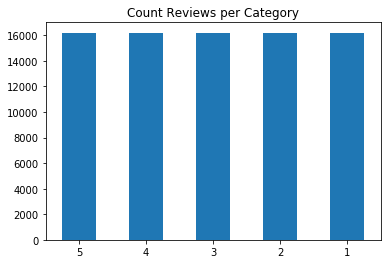

In [74]:
data['star_rating'].value_counts().sort_values().plot(kind='bar', title='Count Reviews per Category', rot=0)

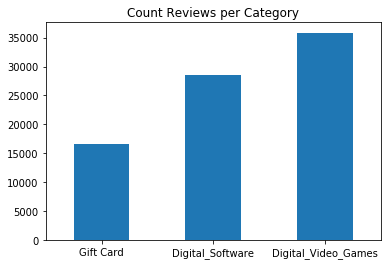

In [75]:
data['product_category'].value_counts().sort_values().plot(kind='bar', title='Count Reviews per Category', rot=0)

# Create Model

In [76]:
# with jsonline['features'][1] as model input
#training_job_name='tensorflow-training-2021-01-27-00-14-06-628'

In [77]:
# with jsonline['features'][0] as model input
# training_job_name='tensorflow-training-2021-01-27-21-01-56-775'

In [78]:
# # updated inference.py with correct json parsing
# training_job_name='tensorflow-training-2021-01-27-23-37-00-180'

In [79]:
import sagemaker

inference_image_uri = sagemaker.image_uris.retrieve(
    framework="tensorflow",
    region=region,
    version="2.3.1",
    py_version="py37",
    instance_type='ml.m5.4xlarge',
    image_scope="inference"
)
print(inference_image_uri)

763104351884.dkr.ecr.us-east-1.amazonaws.com/tensorflow-inference:2.3.1-cpu


In [80]:
# import time

# timestamp = int(time.time())

# bias_model_name = '{}-{}-{}'.format(training_job_name, 'tf', timestamp)

# try:
model_name = sess.create_model_from_job(
    training_job_name=training_job_name,
    image_uri=inference_image_uri
)
# except:
#     pass

Using already existing model: tensorflow-training-2021-01-28-01-19-50-987


In [81]:
print(model_name)

tensorflow-training-2021-01-28-01-19-50-987


# Detecting Bias with Amazon SageMaker Clarify

SageMaker Clarify helps you detect possible pre- and post-training biases using a variety of metrics.

## We need to change this to a dedicated Clarify Image
                         
`clarify_processor = clarify.SageMakerClarifyProcessor(...
        clarify_processor.image_uri = xxx`

In [82]:
from sagemaker import clarify

clarify_processor = clarify.SageMakerClarifyProcessor(role=role,
                                                      instance_count=1,
                                                      instance_type='ml.c5.2xlarge',
                                                      sagemaker_session=sess)

# patch image in Thundera devo account. It is the initial launch image plus the JSONLines bug fix
clarify_processor.image_uri = "678264136642.dkr.ecr.us-east-1.amazonaws.com/sagemaker-clarify-processing:1.0_jsonlines_patch"

# Post-training Bias
Computing post-training bias metrics does require a trained model.

Unbiased training data (as determined by concepts of fairness measured by bias metric) may still result in biased model predictions after training. Whether this occurs depends on several factors including hyperparameter choices.


You can run these options separately with `run_pre_training_bias()` and `run_post_training_bias()` or at the same time with `run_bias()` as shown below.

## Writing DataConfig and ModelConfig
A `DataConfig` object communicates some basic information about data I/O to Clarify. We specify where to find the input dataset, where to store the output, the target column (`label`), the header names, and the dataset type.

Similarly, the `ModelConfig` object communicates information about your trained model and `ModelPredictedLabelConfig` provides information on the format of your predictions.  

**Note**: To avoid additional traffic to your production models, SageMaker Clarify sets up and tears down a dedicated endpoint when processing. `ModelConfig` specifies your preferred instance type and instance count used to run your model on during Clarify's processing.

In [83]:
#post_train_dataset = data[['star_rating', 'product_category', 'review_body']]

In [84]:
#post_train_dataset.head()

# Select n samples across each category

## _Note: We need to have >1 product_categories (facet values) in our training data._

In [85]:
# test_data = post_train_dataset.groupby('product_category', group_keys=False).apply(lambda s: s.sample(5))
# test_data.reset_index(drop=True, inplace=True)
# test_data.shape

In [86]:
# test_data.head()

# Convert To Categorical dtype

## _Note: Otherwise Clarify converts (int) and (str) to continuous threshold values instead of categorical values._

In [87]:
# test_data['product_category'] = test_data['product_category'].astype('category')

In [88]:
# test_data['product_category'].dtype

In [89]:
# test_data['star_rating'] = test_data['star_rating'].astype('category')

In [90]:
# test_data['star_rating'].dtype

# Write as `jsonlines` Format and Upload To S3

In [94]:
path = './data-clarify/test_bias.jsonl'


# TODO:  Fix this file ^^ by updating the MAGIC CODE in 05_Prepare_DataSet.  We need more data, according to X

In [107]:
!cat $path

"{\"features\": [\"i like the gift cards, if you need something quick and easy you can get the gift cards there easy to use, and you can get the amount on them you need in no time at all\", \"Gift Card\", 5]}","{\"features\": [\"Beautiful card, the person receiving this also liked it very much.\", \"Gift Card\", 5]}","{\"features\": [\"The Amazon Gift Card is the Perfect Gift sometimes.  And our grandchildren loved them!\", \"Gift Card\", 5]}","{\"features\": [\"ilove\", \"Gift Card\", 5]}","{\"features\": [\"I love Hoops and Yoyo. It is fun.\", \"Gift Card\", 5]}"

In [95]:
# path = './data-clarify/post_train_data.jsonl'
# test_data.to_json(path, orient="records", lines=True)

In [96]:
post_train_dataset_s3_uri = sess.upload_data(bucket=bucket, key_prefix=training_job_name, path=path)
post_train_dataset_s3_uri

's3://sagemaker-us-east-1-835319576252/tensorflow-training-2021-01-28-01-19-50-987/test_bias.jsonl'

# Configure Clarify

In [97]:
bias_report_output_path = 's3://{}/{}/clarify-bias'.format(bucket, training_job_name)

data_config = clarify.DataConfig(s3_data_input_path=post_train_dataset_s3_uri,
                                 s3_output_path=bias_report_output_path,
                                 label='star_rating',
                                 features='features',
                                 # label must be last, features in exact order as passed into model
                                 headers=['review_body', 'product_category', 'star_rating'],
                                 dataset_type='application/jsonlines')

In [98]:
model_config = clarify.ModelConfig(model_name=model_name,
                                   instance_type='ml.m5.4xlarge',
                                   instance_count=1,
                                   content_type='application/jsonlines',
                                   accept_type='application/jsonlines',
                                   # {"features": ["Digital_Software","the worst"]}
                                   content_template='{"features":$features}'
                                  )

## _Note: `label` is set to the JSON key for the model prediction results_

In [99]:
predictions_config = clarify.ModelPredictedLabelConfig(label='predicted_label')

## Run Clarify

In [100]:
bias_config = clarify.BiasConfig(label_values_or_threshold=[5,4], # needs to be int or str for continuous dtype, needs to be >1 for categorical dtype
                                facet_name='product_category',
                                facet_values_or_threshold=['Gift Card'],
                                group_name='product_category')

In [101]:
clarify_processor.run_post_training_bias(
    data_config=data_config,
    data_bias_config=bias_config,
    model_config=model_config,
    model_predicted_label_config=predictions_config,
#    methods='all', # FlipTest requires all columns to be numeric
    methods=['DPPL', 'DI', 'DCA', 'DCR', 'RD', 'DAR', 'DRR', 'AD', 'CDDPL', 'TE'],
    wait=False,
    logs=False)


Job Name:  Clarify-Posttraining-Bias-2021-01-28-08-15-46-071
Inputs:  [{'InputName': 'dataset', 'AppManaged': False, 'S3Input': {'S3Uri': 's3://sagemaker-us-east-1-835319576252/tensorflow-training-2021-01-28-01-19-50-987/test_bias.jsonl', 'LocalPath': '/opt/ml/processing/input/data', 'S3DataType': 'S3Prefix', 'S3InputMode': 'File', 'S3DataDistributionType': 'FullyReplicated', 'S3CompressionType': 'None'}}, {'InputName': 'analysis_config', 'AppManaged': False, 'S3Input': {'S3Uri': 's3://sagemaker-us-east-1-835319576252/Clarify-Posttraining-Bias-2021-01-28-08-15-46-071/input/analysis_config/analysis_config.json', 'LocalPath': '/opt/ml/processing/input/config', 'S3DataType': 'S3Prefix', 'S3InputMode': 'File', 'S3DataDistributionType': 'FullyReplicated', 'S3CompressionType': 'None'}}]
Outputs:  [{'OutputName': 'analysis_result', 'AppManaged': False, 'S3Output': {'S3Uri': 's3://sagemaker-us-east-1-835319576252/tensorflow-training-2021-01-28-01-19-50-987/clarify-bias', 'LocalPath': '/opt/ml

In [103]:
run_post_training_bias_processing_job_name = clarify_processor.latest_job.job_name
run_post_training_bias_processing_job_name

'Clarify-Posttraining-Bias-2021-01-28-08-15-46-071'

In [104]:
from IPython.core.display import display, HTML

display(HTML('<b>Review <a target="blank" href="https://console.aws.amazon.com/sagemaker/home?region={}#/processing-jobs/{}">Processing Job</a></b>'.format(region, run_post_training_bias_processing_job_name)))


In [105]:
from IPython.core.display import display, HTML

display(HTML('<b>Review <a target="blank" href="https://console.aws.amazon.com/cloudwatch/home?region={}#logStream:group=/aws/sagemaker/ProcessingJobs;prefix={};streamFilter=typeLogStreamPrefix">CloudWatch Logs</a> After About 5 Minutes</b>'.format(region, run_post_training_bias_processing_job_name)))


In [106]:
from IPython.core.display import display, HTML

display(HTML('<b>Review <a target="blank" href="https://s3.console.aws.amazon.com/s3/buckets/{}/{}/?region={}&tab=overview">S3 Output Data</a> After The Processing Job Has Completed</b>'.format(bucket, run_post_training_bias_processing_job_name, region)))


In [ ]:
running_processor = sagemaker.processing.ProcessingJob.from_processing_name(processing_job_name=run_post_training_bias_processing_job_name,
                                                                            sagemaker_session=sess)

processing_job_description = running_processor.describe()

print(processing_job_description)

In [ ]:
running_processor.wait(logs=False)

#### Viewing the Bias Report
In Studio, you can view the results under the experiments tab.

<img src="img/bias_report.gif">

Each bias metric has detailed explanations with examples that you can explore.

<img src="img/bias_detail.gif">

You could also summarize the results in a handy table!

<img src="img/bias_report_chart.gif">


If you're not a Studio user yet, you can access the bias report in pdf, html and ipynb formats in the following S3 bucket:

# Download Report From S3

In [ ]:
!aws s3 ls $bias_report_output_path/

In [ ]:
!aws s3 cp --recursive $bias_report_output_path ./generated_bias_report/

In [ ]:
from IPython.core.display import display, HTML

display(HTML('<b>Review <a target="blank" href="./generated_bias_report/report.html">Bias Report</a></b>'))


# Release Resources

In [ ]:
%%html

<p><b>Shutting down your kernel for this notebook to release resources.</b></p>
<button class="sm-command-button" data-commandlinker-command="kernelmenu:shutdown" style="display:none;">Shutdown Kernel</button>
        
<script>
try {
    els = document.getElementsByClassName("sm-command-button");
    els[0].click();
}
catch(err) {
    // NoOp
}    
</script>

In [ ]:
%%javascript

try {
    Jupyter.notebook.save_checkpoint();
    Jupyter.notebook.session.delete();
}
catch(err) {
    // NoOp
}